In [1]:
# setting seeds, checking for tf 2.x
import numpy as np
import tensorflow as tf
np.random.seed(42)
print(f'TF version: {tf.__version__}')

TF version: 2.1.0


# SVM vs. PyTorch vs. TensorFlow

> Linear soft-margin support-vector machine (gradient-descent) implementation in PyTorch and TensorFlow 2.x (and comparison to scikit-learn).
> 
> **Teaching Material:** Getting used to ML frameworks and automatic differentiation.

![SVM, see https://en.wikipedia.org/wiki/Support_vector_machine](https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/512px-SVM_margin.png)

**Hard-margin SVM** objective given data $((x_i,y_i))_{i=1}^n$:

$$ \min_{w,b} \|w\|^2 \quad \text{subject to} \quad y_i(w \cdot x_i - b) \ge 1, \quad i = 1, \ldots, n.$$

Does only work for linearly seperable data!

Solution: **Soft-Margin SVM** objective with regularization parameter $C > 0$:

$$ \min_{w,b}  \ \lVert w \rVert^2 + C\left[\frac 1 n \sum_{i=1}^n \underbrace{\max\left(0, 1 - y_i(w\cdot x_i - b)\right)}_{\text{hinge loss}} \right]$$


- $C$ represents a trade-off between increasing the margin size (smaller $C$) and ensuring that the $x_{i}$ lie on the correct side of the margin (larger $C$)

- After finding (approximate) minimizer $\hat{w}, \hat{b}$, the classifier is given by $x \mapsto \operatorname{sgn}(\hat{w} x-\hat{b})$. 

## Data

We use a predefined scikit-learn dataset.

In [2]:
from sklearn.datasets import make_blobs

X, Y = make_blobs(n_samples=200, centers=[(-1, -1), (1, 1)], cluster_std=0.5)
Y[Y == 0] = -1 # to have +/- 1 labels

Let us plot the data (see the `svm_utils` module for details).

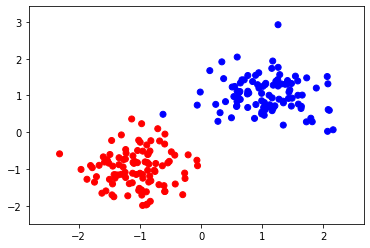

In [3]:
from svm_utils import plot
plot(X, Y)

## Scikit-Learn

... very easy to use!

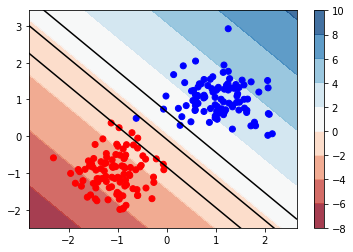

In [4]:
from sklearn.svm import LinearSVC
C = 1.0

clf = LinearSVC(penalty='l2', loss='hinge', C=C)
clf.fit(X, Y)

plot(X, Y, W=clf.coef_.T, b=-clf.intercept_)

## Naive PyTorch and TensorFlow gradient descent

**Disclaimer**: 
- This is just for the purpose of getting used to the [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) of PyTorch and Tensorflow

- Usually, one does **not** solve the (non-smooth) SVM objective using plain gradient descent, but, e.g. using [quadratic programming, interior-point methods, sub-gradient/coordinate descent, sequential minimal optimization](https://en.wikipedia.org/wiki/Support-vector_machine#Implementation)

### Data

We cast the arrays to 32-bit float and reshape Y to a 2D array.

In [5]:
Y_2d = Y[:,np.newaxis].astype('f') 
print(f' Y shape: {Y.shape}, Y_2d shape: {Y_2d.shape}')
X = X.astype('f') 

# tensorflow
import tensorflow as tf
X_t = tf.constant(X)
Y_t = tf.constant(Y_2d)

# pytorch
import torch
X_p = torch.tensor(X) 
Y_p = torch.tensor(Y_2d) 

 Y shape: (200,), Y_2d shape: (200, 1)


### Model

To compare TF and PyTorch we use numpy random initializations. Note that we want to compute gradients w.r.t. to W and b later.

In [6]:
W = np.random.rand(2,1).astype('f') 
b = np.random.rand(1,1).astype('f') 

# tensorflow
W_t = tf.Variable(W)
b_t = tf.Variable(b)

# pytorch
W_p = torch.tensor(W, requires_grad=True) 
b_p = torch.tensor(b, requires_grad=True)

### Loss

Recall our objective:

$$ \min_{w,b}  \ \lVert w \rVert^2 + C\left[\frac 1 n \sum_{i=1}^n \underbrace{\max\left(0, 1 - y_i(w\cdot x_i - b)\right)}_{\text{hinge loss}} \right]$$.

In [7]:
# tensorflow 
def soft_margin_loss_t():
    pred = X_t @ W_t - b_t # @ denotes the usual matrix product
    hinge = tf.math.reduce_mean(tf.keras.losses.hinge(Y_t, pred))
    tikhonov = tf.math.reduce_sum(0.5*(W_t**2)) # one could understand this as a L2/Tikhonov regularization
    return C*hinge + tikhonov

# pytorch
def hinge_loss(t):
    loss = 1-t 
    loss[loss < 0] = 0 # PyTorch supports 'numpy-style' indexing
    return loss

def soft_margin_loss_p():
    pred = X_p @ W_p - b_p 
    hinge = hinge_loss(pred*Y_p).mean()
    tikhonov = 0.5*(W_p**2).sum()
    return C*hinge + tikhonov

Let's plot the hinge loss:

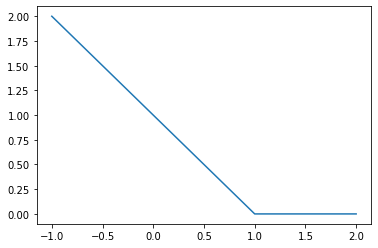

In [8]:
from matplotlib import pyplot as plt

t = torch.linspace(-1,2)
plt.plot(t, hinge_loss(t)) # PyTorch works well with matplotlib
plt.show() 

Lets check that the inital loss is equal.

In [9]:
print(f'Loss TF: {soft_margin_loss_t()}, Loss PyTorch: {soft_margin_loss_p()}')

Loss TF: 0.5553568005561829, Loss PyTorch: 0.5553567409515381


### Gradient Descent

Let use automatic differentiation (AD) to perform gradient descent.

**Tensorflow:** [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) ... records operations for AD if at least one of their inputs is being "watched" (e.g. a `tf.Variable`)

**PyTorch:** [loss.backward()](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html?highlight=autograd) ... compute gradients of `loss` w.r.t. tensors occuring in the computational graph of loss for which `requires_grad=True`

![Autograd PyTorch, see https://github.com/pytorch](https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/dynamic_graph.gif)

In [10]:
# tensorflow
def gradient_step_t(lr=0.1):
    with tf.GradientTape() as tape: 
        loss = soft_margin_loss_t()
        grads = tape.gradient(loss, [W_t, b_t])
    W_t.assign(W_t - lr*grads[0])
    b_t.assign(b_t - lr*grads[1])
    return loss.numpy()

# pytorch
def gradient_step_p(lr=0.1):
    loss = soft_margin_loss_p()
    loss.backward() 
    W_p.data -= lr*W_p.grad
    b_p.data -= lr*b_p.grad
    W_p.grad.zero_() # set gradients to zero (otherwise next gradients will be added)
    b_p.grad.zero_()
    return loss.item() 

In [11]:
steps = 500

for i in range(steps):
    loss_t = gradient_step_t()
    loss_p = gradient_step_p()
    if not i%100:
        print(f'Step: {i:03d}, Loss TF: {loss_t:.05f} Loss PyTorch: {loss_p:.05f}')

Step: 000, Loss TF: 0.55536 Loss PyTorch: 0.55536
Step: 100, Loss TF: 0.35888 Loss PyTorch: 0.35888
Step: 200, Loss TF: 0.35888 Loss PyTorch: 0.35888
Step: 300, Loss TF: 0.35888 Loss PyTorch: 0.35888
Step: 400, Loss TF: 0.35887 Loss PyTorch: 0.35887


Let us see whether the outputs coincide:

In [12]:
W_p_final = W_p.detach().numpy() # detach it from the computational graph
b_p_final = b_p.detach().numpy()

print('TF W:', W_t.numpy() , 'PyTorch W:', W_p_final, 'TF b:', b_t.numpy(), 'PyTorch b:', b_p_final, sep='\n')

TF W:
[[0.46348655]
 [0.4440725 ]]
PyTorch W:
[[0.46348655]
 [0.4440725 ]]
TF b:
[[0.00080997]]
PyTorch b:
[[0.00081002]]


Plot the result and compare it to the sklearn prediction.

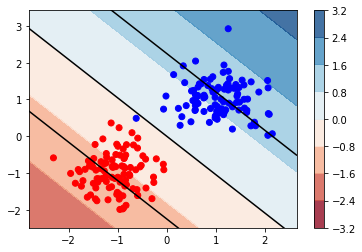

In [13]:
# pytorch
plot(X, Y, W=W_p_final, b=b_p_final.ravel())

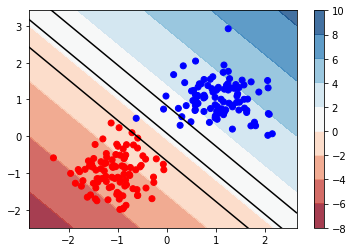

In [14]:
# sklearn
plot(X, Y, W=clf.coef_.T, b=clf.intercept_)

## Unleashing (a little bit of) the power of PyTorch and TensorFlow

Actually we can get similar implementations easier and much more extendible in both frameworks!! 

Let us start with **PyTorch** (we use a dataloader from `torch.utils.data` for the data pipeline, a class inheriting from `torch.nn.module` for the model, and an optimizer from `torch.optim`).

In [15]:
from torch.utils.data import TensorDataset, DataLoader

dataloader = DataLoader(TensorDataset(X_p, Y_p), shuffle=True, batch_size=10) # create dataloader
model = torch.nn.Linear(2,1) # create linear model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # create SGD optimizer

print(f' W: {model.weight}')

 W: Parameter containing:
tensor([[0.3037, 0.5630]], requires_grad=True)


Training loop:

In [16]:
def train(epochs=6):
    for i in range(epochs):
        for X_batch, Y_batch in dataloader:
            optimizer.zero_grad() # zero the gradient buffers
            pred = model(X_batch)
            loss = C*hinge_loss(pred*Y_batch).mean() + (model.weight**2).sum()
            loss.backward() 
            optimizer.step() # does the update 
        print(f'Epoch: {i}, Loss: {loss.item()}')

Epoch: 0, Loss: 0.5550767183303833
Epoch: 1, Loss: 0.4517517685890198
Epoch: 2, Loss: 0.44555261731147766
Epoch: 3, Loss: 0.4827623963356018
Epoch: 4, Loss: 0.6334421634674072
Epoch: 5, Loss: 0.5586197376251221


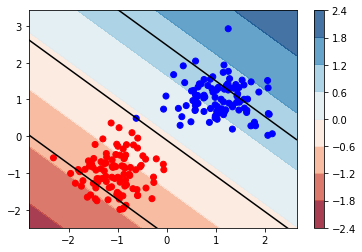

In [17]:
train()
plot(X, Y, W=model.weight.t().detach().numpy(), b=-model.bias.detach().numpy())

Lets switch to **Tensorflow/Keras**:

In [18]:
from tensorflow import keras

dataset = tf.data.Dataset.from_tensor_slices((X_t, Y_t)).shuffle(10).batch(10) # create dataset
model = keras.Sequential() # create model
model.add(keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(1.))) # linear model with L2 reg.
model.compile(optimizer=tf.keras.optimizers.SGD(0.1), loss=tf.keras.losses.Hinge()) # 'compile' the model
history = model.fit(dataset, epochs=5)

Train for 20 steps
Epoch 1/5
20/20 [==============================] - 0s 22ms/step - loss: 0.6330
Epoch 2/5
20/20 [==============================] - 0s 5ms/step - loss: 0.5324
Epoch 3/5
20/20 [==============================] - 0s 5ms/step - loss: 0.5350
Epoch 4/5
20/20 [==============================] - 0s 4ms/step - loss: 0.5344
Epoch 5/5
20/20 [==============================] - 0s 5ms/step - loss: 0.5349


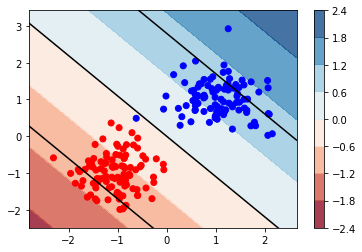

In [19]:
plot(X, Y, W=model.layers[0].kernel.numpy(), b=-model.layers[0].bias.numpy())

## ~~Don't~~  Try this at home

Try different datasets, regularization parameters, losses (squared hinge-loss), Kernel-SVM, (logistic) regression, neural networks ...

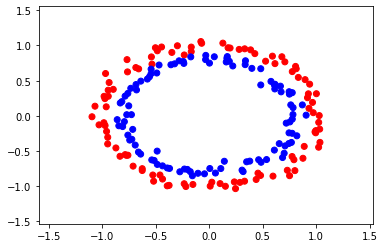

In [20]:
from sklearn.datasets import make_circles

X, Y = make_circles(n_samples=200, noise=0.05)
Y[Y == 0] = -1 #to have +/- 1 labels
plot(X, Y)

Linear SVM has a hard time...

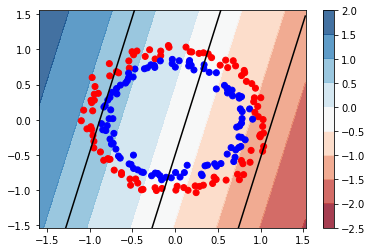

In [21]:
clf = LinearSVC(penalty='l2', loss='hinge', C=C)
clf.fit(X, Y)
plot(X, Y, W=clf.coef_.T, b=-clf.intercept_)

In [22]:
# e.g.
#
# C = 0.5
#
# from sklearn.svm import SVC
# clf = SVC(C=C, kernel='rbf')
#
#
# from torch import nn
# model = nn.Sequential(
#          nn.Linear(2,6),
#          nn.ReLU(),
#          nn.Linear(6,6),
#          nn.ReLU(),
#          nn.Linear(6,1)
#        )
#
#
#
#

Further introductory material:

[PyTorch Tutorials](https://pytorch.org/tutorials/)

[TensorFlow Tutorials](https://www.tensorflow.org/learn)  

[fast.ai course](https://course.fast.ai/index.html)